# TP3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

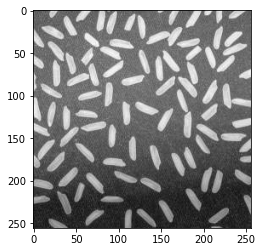

In [2]:
img = cv2.imread("Images/rice.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")

### Saisie du seuil

In [3]:
def Fseuillagesaisi(img):
    # Calculate and plot histogram
    hist = cv2.calcHist([img], channels=[0], mask=None, histSize=[256], ranges=[0,256])
    plt.figure(figsize=(10,5))
    plt.plot(hist)
    plt.title('Histogram')
    plt.show()
    
    # User input
    print('Enter threshold :')
    threshold = np.float32(input())
    
    # Get binary outputs and display them
    # img_f = img >= threshold # Foreground image
    # img_b = img < threshold # Background image
    _, img_f = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY) # Foreground image
    _, img_b = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV) # Background image
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_f, cmap="gray")
    plt.colorbar()
    plt.title('Foreground image')
    plt.subplot(1,2,2)
    plt.imshow(img_b, cmap="gray")
    plt.colorbar()
    plt.title('Background image')

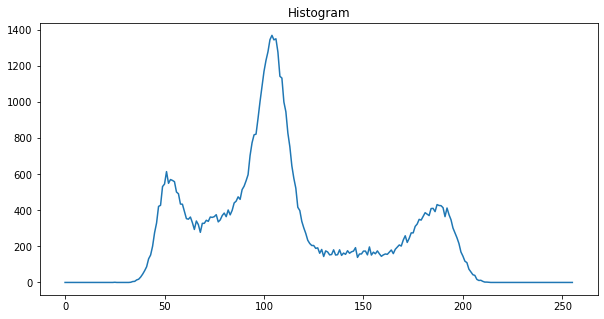

Enter threshold :


 150


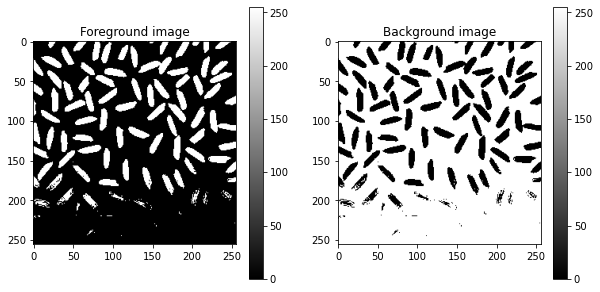

In [5]:
Fseuillagesaisi(img)

### Seuillage par incrémentation

In [7]:
def Fseuillageboucle(img):
    for i in range(256):
        _, img_th = cv2.threshold(img, np.float32(i), 255, cv2.THRESH_BINARY)
        cv2.imshow("Thresholded image", img_th)
        cv2.waitKey(50) # ms
        
    cv2.destroyAllWindows()

In [8]:
Fseuillageboucle(img)

### Seuillage par recherche du 1er minimum d’intensité après le 1er maximum

In [116]:
def Fseuilrecherche(img, left=True):
    # Calculate and plot histogram
    hist = cv2.calcHist([img], channels=[0], mask=None, histSize=[256], ranges=[0,256])
    plt.figure(figsize=(10,5))
    plt.plot(hist)
    plt.title('Histogram')
    plt.show()
    
    # Compute threshold
    signs = np.sign(np.diff(hist, axis=0)) # Find extrema
    corr = cv2.filter2D(signs, -1, np.array([1, -1])) # Correlation
    maxVals = np.where(corr == 2)[0]
    minVals = np.where(corr == -2)[0]
    if left:
        return minVals[np.where(minVals > maxVals[0])[0][0]]
    else:
        return 0 ## TO DO

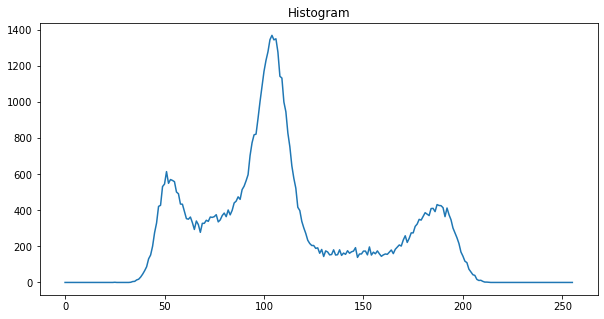

52


In [117]:
threshold = Fseuilrecherche(img)
print(threshold)

### Seuillage par recherche du 1 er minimum d’intensité après le 1 er maximum et après filtrage de la courbe des fréquences d’intensité

In [125]:
def Ffiltrage(img, indexMax=0, left=True):
    # Calculate and plot histogram
    hist = cv2.calcHist([img], channels=[0], mask=None, histSize=[256], ranges=[0,256])
    hist_filt = cv2.GaussianBlur(hist, (0,0), 10)
    plt.figure(figsize=(10,5))
    plt.plot(hist_filt)
    plt.title('Filtered Histogram')
    plt.show()
    
    # Compute threshold
    signs = np.sign(np.diff(hist_filt, axis=0)) # Find extrema
    corr = cv2.filter2D(signs, -1, np.array([1, -1])) # Correlation
    maxVals = np.where(corr == 2)[0]
    minVals = np.where(corr == -2)[0]
    if left:
        return minVals[np.where(minVals > maxVals[indexMax])[0][0]]
    else:
        return 0 ## TO DO

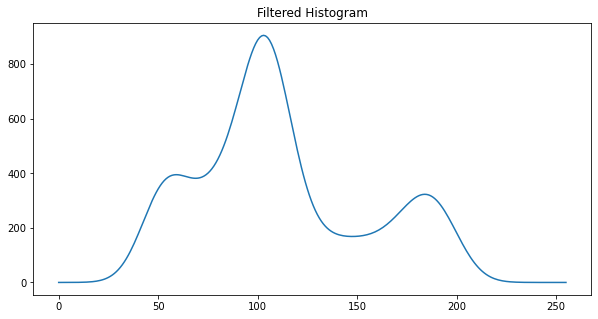

148


In [126]:
threshold = Ffiltrage(img, indexMax=1)
print(threshold)

### Seuillage automatique par maximisation de la variance inter-classes

In [45]:
def Fseuillagemaxvariance(img):
    hist = cv2.calcHist([img], channels=[0], mask=None, histSize=[256], ranges=[0,256])
    ramp = np.array([i for i in range(256)]).reshape(-1, 1) # Give ramp the same shape as hist
    
    N = np.sum(hist) # Total population
    # N = np.prod(img.shape)
    M = np.sum(hist * ramp) / N # Image mean
    # M = np.mean(img)
    
    Vs = [] # Interclass variance
    for s in range(256):
        # Class 0
        N0s  = np.sum(hist[0:s]) # Population
        if N0s != 0:
            M0s = np.sum(hist[0:s] * ramp[0:s]) / N0s # Mean
        else:
            M0s = 0
        pC0s = N0s / N # Probability
        
        # Class 1
        N1s  = np.sum(hist[s+1:]) # Population
        if N1s != 0:
            M1s  = np.sum(hist[s+1:] * ramp[s+1:]) / N1s # Mean
        else:
            pCM1s1s = 0
        pC1s = N1s / N # Probability
        
        Vs.append(pC0s * (M0s - M)**2 + pC1s * (M1s - M)**2)
        
    return np.argmax(Vs), Vs

Custom threshold : 131
Otsu threshold   : 131.0


Text(0.5, 1.0, 'Background image')

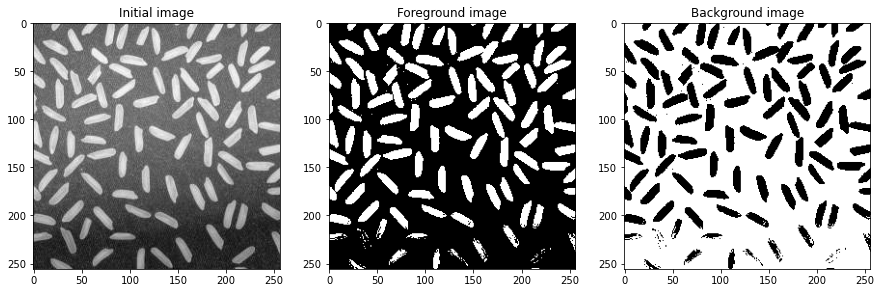

In [50]:
# Custom Otsu thresholding
threshold_custom, Vs0 = Fseuillagemaxvariance(img)

# Otsu's thresholding using OpenCV
threshold_otsu, img_otsu_f = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Foreground image
threshold_otsu, img_otsu_b = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Background image

print("Custom threshold : " + str(threshold_custom))
print("Otsu threshold   : " + str(threshold_otsu))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title('Initial image')
plt.subplot(1,3,2)
plt.imshow(img_otsu_f, cmap="gray")
plt.title('Foreground image')
plt.subplot(1,3,3)
plt.imshow(img_otsu_b, cmap="gray")
plt.title('Background image')